In [ ]:
import re
import time

import numpy as np
from scipy.special import softmax
import unicodedata

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint, CheckpointManager
from transformers import TFAutoModel, AutoTokenizer

from sklearn.metrics import f1_score, classification_report

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert = TFAutoModel.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/706M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
aspect2id = {
    'ROOM_AMENITIES': 0,
    'SERVICE' : 1,
    'ROOMS' : 2,
    'LOCATION': 3,
    'FOOD&DRINKS' : 4,
    'FACILITIES': 5,
    'HOTEL': 6,
}

In [ ]:
def get_vocab(file):
    word2id = {}
    r = open(file, 'r', encoding='utf-8')
    count = 1
    for word in r.read().split('\n'):
        word2id[word] = count
        count += 1
    r.close()
    return word2id

word2id = get_vocab('wordset/hotel_vocab.txt')

In [ ]:
num_aspects = len(aspect2id)

In [ ]:
def get_seed(file):
    seed_set = {}
    r = open(file, 'r', encoding='utf-8')
    seeds = r.read().split('\n')[0:-1]
    for i in range(len(seeds)):
        seeds[i] = seeds[i].split('|')[:-1]
        seed_tokens = []
        for seed in seeds[i]:
            if seed in word2id:
                seed_tokens.append(word2id[seed])
            else:
                seed_tokens.append(-1)
        seed_set[i] = seed_tokens
    r.close()
    return seed_set

seed_set = get_seed('wordset/hotel_seeds.txt')

In [ ]:
def get_train_tokens(file):
    r = open(file, 'r', encoding='utf-8')
    docs = r.readlines()
    inps = []
    for i in range(len(docs)):
        docs[i] = docs[i].split()
        inp = [word2id[word] for word in docs[i]]
        inps.append(inp)
    r.close()
    return inps

train_tokens = get_train_tokens('processed/hotel_train.txt')

In [ ]:
def get_train_inp(file):
    r = open(file, 'r', encoding='utf-8')
    docs = r.read().split('\n')[:-1]
    r.close()

    inps = [tokenizer.encode(line) for line in docs]
    return inps
train_inp = get_train_inp('processed/hotel_train.txt')

In [ ]:
def get_test(file):
    r = open(file, 'r', encoding='utf-8')
    lines = r.readlines()
    toks = []
    inps = []
    outs = []
    for line in lines:
        sent = line.split('|')[0]
        tok = []
        tok = [word2id[word] for word in sent.split() if word in word2id]
        toks.append(tok)

        sent = line.split('|')[0]
        inp = tokenizer.encode(line)
        inps.append(inp)
        
        #print(line)
        aspect = line.split('|')[1][:-1]
        label = aspect2id[aspect]
        out = [0 for i in range(num_aspects)]
        out[label] = 1
        outs.append(out)
    
    r.close()
    return toks, inps, np.array(outs)

dev_tokens, dev_inp, dev_out = get_test('processed/hotel_dev.txt')
test_tokens, test_inp, test_out = get_test('processed/hotel_test.txt')

In [ ]:
def get_test(file):
    r = open(file, 'r', encoding='utf-8')
    lines = r.readlines()
    inps = []
    outs = []
    for line in lines:
        sent = line.split('|')[0]
        inp = tokenizer.encode(line)
        inps.append(inp)
        
        #print(line)
        aspect = line.split('|')[1][:-1]
        label = aspect2id[aspect]
        out = [0 for i in range(num_aspects)]
        out[label] = 1
        outs.append(out)
    
    r.close()
    return inps, np.array(outs)

dev_inp, dev_out = get_test('processed/hotel_dev.txt')
test_inp, test_out = get_test('processed/hotel_test.txt')

In [ ]:
def get_weight_seed(inps, preds, seed_set):
    weight_seed = {}
    for label in seed_set:
        for seed in seed_set[label]:
            weight_seed[seed] = np.zeros(num_aspects)
    
    for i in range(inps.shape[0]):
        for label in seed_set:
            for seed in seed_set[label]:
                if seed in inps[i]:
                    weight_seed[seed][preds[i]] += 1

    for label in seed_set:
        for seed in seed_set[label]:
            sum = np.sum(weight_seed[seed])
            if sum != 0:
                weight_seed[seed] /= sum    
    
    return weight_seed

In [ ]:
default_weight_seed = {}

for label in seed_set:
    for seed in seed_set[label]:
        default_weight_seed[seed] = np.ones(num_aspects)
        # default_weight_seed[seed] /= np.sum(default_weight_seed[seed]) 

In [ ]:
def get_train_weak_out(inps, seed_set, weight_seed=default_weight_seed):
    outs = []
    for inp in inps:
        out = []
        cnt = 0
        for label in seed_set:
            bow = 0
            for seed in seed_set[label]:
                bow += np.count_nonzero(inp == seed) * weight_seed[seed][label]
            if bow == 0:
                cnt += 1
            out.append(bow)
    
        if cnt == len(seed_set):
            out[-1] = 10000000
        outs.append(out)

    outs = softmax(outs, axis=1)
    return outs

# Visualize data

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

<BarContainer object of 92 artists>

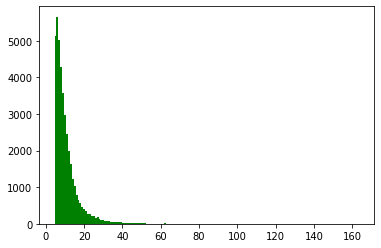

In [ ]:
len_train_inp = [len(inp) for inp in train_inp]
len_train_inp = Counter(len_train_inp)
plt.bar(len_train_inp.keys(), len_train_inp.values(), width=1, color='g')

<BarContainer object of 30 artists>

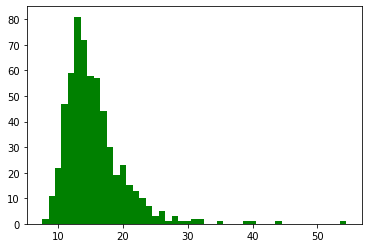

In [ ]:
len_test_inp = [len(inp) for inp in test_inp]
len_test_inp = Counter(len_test_inp)
plt.bar(len_test_inp.keys(), len_test_inp.values(), width=1, color='g')

<BarContainer object of 7 artists>

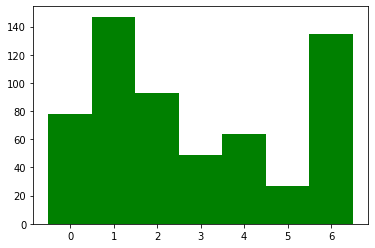

In [ ]:
test_label = np.argmax(test_out, axis=1)
len_test_label = Counter(test_label)
plt.bar(len_test_label.keys(), len_test_label.values(), width=1, color='g')

# Create dataset

In [ ]:
max_len = 30

train_inp = pad_sequences(train_inp, maxlen=max_len, value=1, padding='post')
dev_inp = pad_sequences(dev_inp, maxlen=max_len, value=1, padding='post')
test_inp = pad_sequences(test_inp, maxlen=max_len, value=1, padding='post')

In [ ]:
train_attention_mask = np.where(train_inp == 1, 0, 1)
dev_attention_mask = np.where(dev_inp == 1, 0, 1)
test_attention_mask = np.where(test_inp == 1, 0, 1)

In [ ]:
train_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in train_tokens]
dev_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in dev_tokens]
test_tokens = [inp if len(inp) < max_len else inp[0:max_len] for inp in test_tokens]

In [ ]:
train_tokens = pad_sequences(train_tokens, maxlen=max_len)
dev_tokens = pad_sequences(dev_tokens, maxlen=max_len)
test_tokens = pad_sequences(test_tokens, maxlen=max_len)

# Define model

In [ ]:
class BertModel(Model):
    def __init__(self, pretrained_model=phobert, hidden_dim=100, dropout_rate=0.5, output_dim=num_aspects):
        super().__init__(self)

        self.embedding = pretrained_model
        
        self.hidden = Dense(hidden_dim, activation='relu')
        self.dropout = Dropout(dropout_rate)

        self.dense = Dense(output_dim, activation='softmax')

    def call(self, inputs, attention_mask, training=True):
        x = inputs
        x = self.embedding(x, attention_mask)

        x = x['pooler_output']
        x = self.dropout(x, training=training)

        x = self.hidden(x, training=training)
        x = self.dense(x, training=training)

        return x

In [ ]:
bert_model = BertModel()

In [ ]:
loss_function = CategoricalCrossentropy()
accuracy_function = Accuracy()

train_loss = Mean(name='train_loss')
dev_loss = Mean(name='dev_loss')
test_loss = Mean(name='test_loss')

In [ ]:
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

In [ ]:
EPOCHS = 15
ROUNDS = 3
BUFFER_SIZE = 1000
BATCH_SIZE = 128

In [ ]:
checkpoint_path = "./bert_checkpoints/hotel/"
ckpt = Checkpoint(bert_model, optimizer=optimizer)
ckpt_manager = CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

In [ ]:
@tf.function
def train_step(inp, out, mask):
    with tf.GradientTape() as tape:
        pred = bert_model(inp, mask, True)

        loss = loss_function(out, pred)
    
    gradients = tape.gradient(loss, bert_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bert_model.trainable_variables))

    train_loss(loss)

In [ ]:
def teacher(round, train_inp, train_tokens, train_attention_mask, dev_inp, dev_tokens, dev_attention_mask, dev_out, seed_set):
    print('TEACHER:')
    
    weight_seed = {}

    if round == 0:
        weight_seed = default_weight_seed
    else:
        train_size = train_inp.shape[0]
        student_train_pred = []

        for i in range(0, train_size, BATCH_SIZE):
            first = i
            last = min(i + BATCH_SIZE, train_size)

            # train_tmp = train_inp[first:last], (BATCH_SIZE, train_inp.shape[1]))
            # tmp_mask = train_attention_mask[first:last], (BATCH_SIZE, train_attention_mask.shape[1]))
            
            train_tmp = train_inp[first:last]
            tmp_mask = train_attention_mask[first:last]

            inp = tf.constant(train_tmp)
            mask = tf.constant(tmp_mask)
            preds = bert_model(inp, mask)
            preds = tf.argmax(preds, axis=1)
     
            for pred in preds:
                student_train_pred.append(pred.numpy())
        
        weight_seed = get_weight_seed(train_tokens, student_train_pred, seed_set)
    
    dev_pred = get_train_weak_out(dev_tokens, seed_set, weight_seed)
    
    dev_f1 = f1_score(tf.argmax(dev_out, axis=1), tf.argmax(dev_pred, axis=1), average='macro')

    print(f'Dev F1 Score: {dev_f1:.4f}')
    print()

    return weight_seed

In [ ]:
def student(num_epochs, train_inp, train_tokens, train_attention_mask, dev_inp, dev_attention_mask, dev_out, seed_set, weight_seed):
    print('STUDENT:')
    
    train_out = get_train_weak_out(train_tokens, seed_set, weight_seed)

    train_examples = Dataset.from_tensor_slices((train_inp, train_out, train_attention_mask))

    train_batches = train_examples.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    best_epoch = 0
    best_dev_f1 = 0

    for epoch in range(num_epochs):
        start = time.time()

        train_loss.reset_states()

        for (batch, (inp, out, mask)) in enumerate(train_batches):
            train_step(inp, out, mask)
            if batch % 100 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f}')

        dev_loss.reset_states()

        dev_inp_tensor = tf.constant(dev_inp)
        dev_out_tensor = tf.constant(dev_out)
        dev_attention_mask_tensor = tf.constant(dev_attention_mask)

        dev_pred = bert_model(dev_inp_tensor, dev_attention_mask_tensor, True)
        loss = loss_function(dev_out_tensor, dev_pred)
        dev_f1 = f1_score(tf.argmax(dev_out_tensor, axis=1), tf.argmax(dev_pred, axis=1), average='macro')

        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            best_epoch = epoch
        
        dev_loss(loss)

        if (epoch + 1) % 1 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        
        print(f'Epoch {epoch + 1}: Loss {train_loss.result():.4f}')
    
        print(f'Dev loss: {dev_loss.result():.4f} Dev F1 Score: {dev_f1:.4f}')
    
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    return best_epoch


In [ ]:
epoch = 0

In [ ]:
for round in range(ROUNDS):

    print(f'ROUND {round + 1}:')
    
    # TEACHER
    weight_seed = teacher(round, train_inp, train_tokens, train_attention_mask, dev_inp, dev_tokens, dev_attention_mask, dev_out, seed_set)
        
    # STUDENT
    best_epoch = student(EPOCHS, train_inp, train_tokens, train_attention_mask, dev_inp, dev_attention_mask, dev_out, seed_set, weight_seed) + 1
    epoch = epoch + best_epoch

    print(f'Best epoch: {epoch}')
    ckpt.restore(checkpoint_path + 'ckpt-' + str(epoch))
    print(f'Restore from epoch {epoch}\n')

    teacher_test_pred = get_train_weak_out(test_tokens, seed_set, weight_seed)
    teacher_f1 = f1_score(tf.argmax(test_out, axis=1), tf.argmax(teacher_test_pred, axis=1), average='macro')

    print('TEACHER:')
    print(f'Test F1 Score: {teacher_f1:.4f}\n')


    test_inp_tensor = tf.constant(test_inp)
    test_out_tensor = tf.constant(test_out)
    test_attention_mask_tensor = tf.constant(test_attention_mask)
    student_test_pred = bert_model(test_inp_tensor, test_attention_mask_tensor, True)
    student_f1 = f1_score(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1), average='macro')
    clfrpt = classification_report(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1))

    print('STUDENT:')
    print(f'Test F1 Score: {student_f1:.4f}\n')
    print(clfrpt)


ROUND 1:
TEACHER:
Dev F1 Score: 0.8171

STUDENT:
Epoch 1 Batch 0 Loss 1.9633
Epoch 1 Batch 100 Loss 1.8160
Epoch 1 Batch 200 Loss 1.7396
Epoch 1 Batch 300 Loss 1.6848
Saving checkpoint for epoch 1 at ./bert_checkpoints/hotel/ckpt-1
Epoch 1: Loss 1.6783
Dev loss: 1.3529 Dev F1 Score: 0.5149
Time taken for 1 epoch: 251.40 secs

Epoch 2 Batch 0 Loss 1.5548
Epoch 2 Batch 100 Loss 1.5490
Epoch 2 Batch 200 Loss 1.5503
Epoch 2 Batch 300 Loss 1.5361
Saving checkpoint for epoch 2 at ./bert_checkpoints/hotel/ckpt-2
Epoch 2: Loss 1.5355
Dev loss: 1.2578 Dev F1 Score: 0.5425
Time taken for 1 epoch: 240.95 secs

Epoch 3 Batch 0 Loss 1.5220
Epoch 3 Batch 100 Loss 1.5053
Epoch 3 Batch 200 Loss 1.5071
Epoch 3 Batch 300 Loss 1.4947
Saving checkpoint for epoch 3 at ./bert_checkpoints/hotel/ckpt-3
Epoch 3: Loss 1.4934
Dev loss: 1.1996 Dev F1 Score: 0.6214
Time taken for 1 epoch: 244.57 secs

Epoch 4 Batch 0 Loss 1.5348
Epoch 4 Batch 100 Loss 1.4699
Epoch 4 Batch 200 Loss 1.4737
Epoch 4 Batch 300 Loss 1.4